In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [22]:
class ColorizationDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform_gray = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
        self.transform_color = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # img is PIL Image
        gray = self.transform_gray(img)
        color = self.transform_color(img)
        return gray, color


In [23]:
# Download Oxford-IIIT Pet dataset (images only, no transform here)
base_dataset = datasets.OxfordIIITPet(root="./data", download=True, transform=None)

# Wrap the base dataset with colorization transforms
train_dataset = ColorizationDataset(base_dataset)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [24]:
class SimpleColorCNN(nn.Module):
    def __init__(self):
        super(SimpleColorCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),  # 64x64x64
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 128x32x32
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 256x16x16
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 128x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 64x64x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),  # 3x128x128
            nn.Sigmoid(),  # output normalized [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [15]:
model = SimpleColorCNN().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)


In [25]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for gray, color in tqdm(train_loader):
        gray = gray.to(device)
        color = color.to(device)

        optimizer.zero_grad()
        output = model(gray)
        loss = criterion(output, color)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


100%|██████████| 460/460 [00:29<00:00, 15.51it/s]


Epoch [1/10], Loss: 0.0594


100%|██████████| 460/460 [00:27<00:00, 16.86it/s]


Epoch [2/10], Loss: 0.0500


100%|██████████| 460/460 [00:27<00:00, 16.86it/s]


Epoch [3/10], Loss: 0.0478


100%|██████████| 460/460 [00:27<00:00, 16.90it/s]


Epoch [4/10], Loss: 0.0469


100%|██████████| 460/460 [00:27<00:00, 16.96it/s]


Epoch [5/10], Loss: 0.0465


100%|██████████| 460/460 [00:27<00:00, 17.00it/s]


Epoch [6/10], Loss: 0.0463


100%|██████████| 460/460 [00:27<00:00, 16.94it/s]


Epoch [7/10], Loss: 0.0461


100%|██████████| 460/460 [00:27<00:00, 16.95it/s]


Epoch [8/10], Loss: 0.0456


100%|██████████| 460/460 [00:27<00:00, 16.94it/s]


Epoch [9/10], Loss: 0.0458


100%|██████████| 460/460 [00:27<00:00, 16.98it/s]

Epoch [10/10], Loss: 0.0455


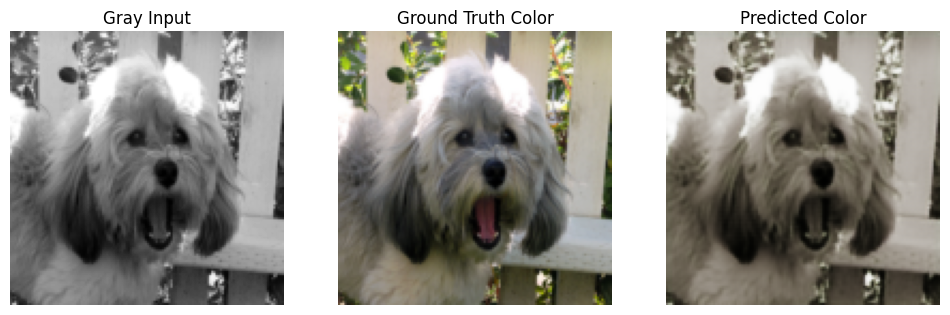

In [26]:
model.eval()
gray_img, color_img = next(iter(train_loader))
gray_img = gray_img.to(device)

with torch.no_grad():
    output = model(gray_img)

# Move to CPU and convert to numpy
gray_np = gray_img[0].cpu().squeeze().numpy()
color_np = color_img[0].permute(1, 2, 0).numpy()
output_np = output[0].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Gray Input")
plt.imshow(gray_np, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Ground Truth Color")
plt.imshow(color_np)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Predicted Color")
plt.imshow(output_np)
plt.axis('off')

plt.show()


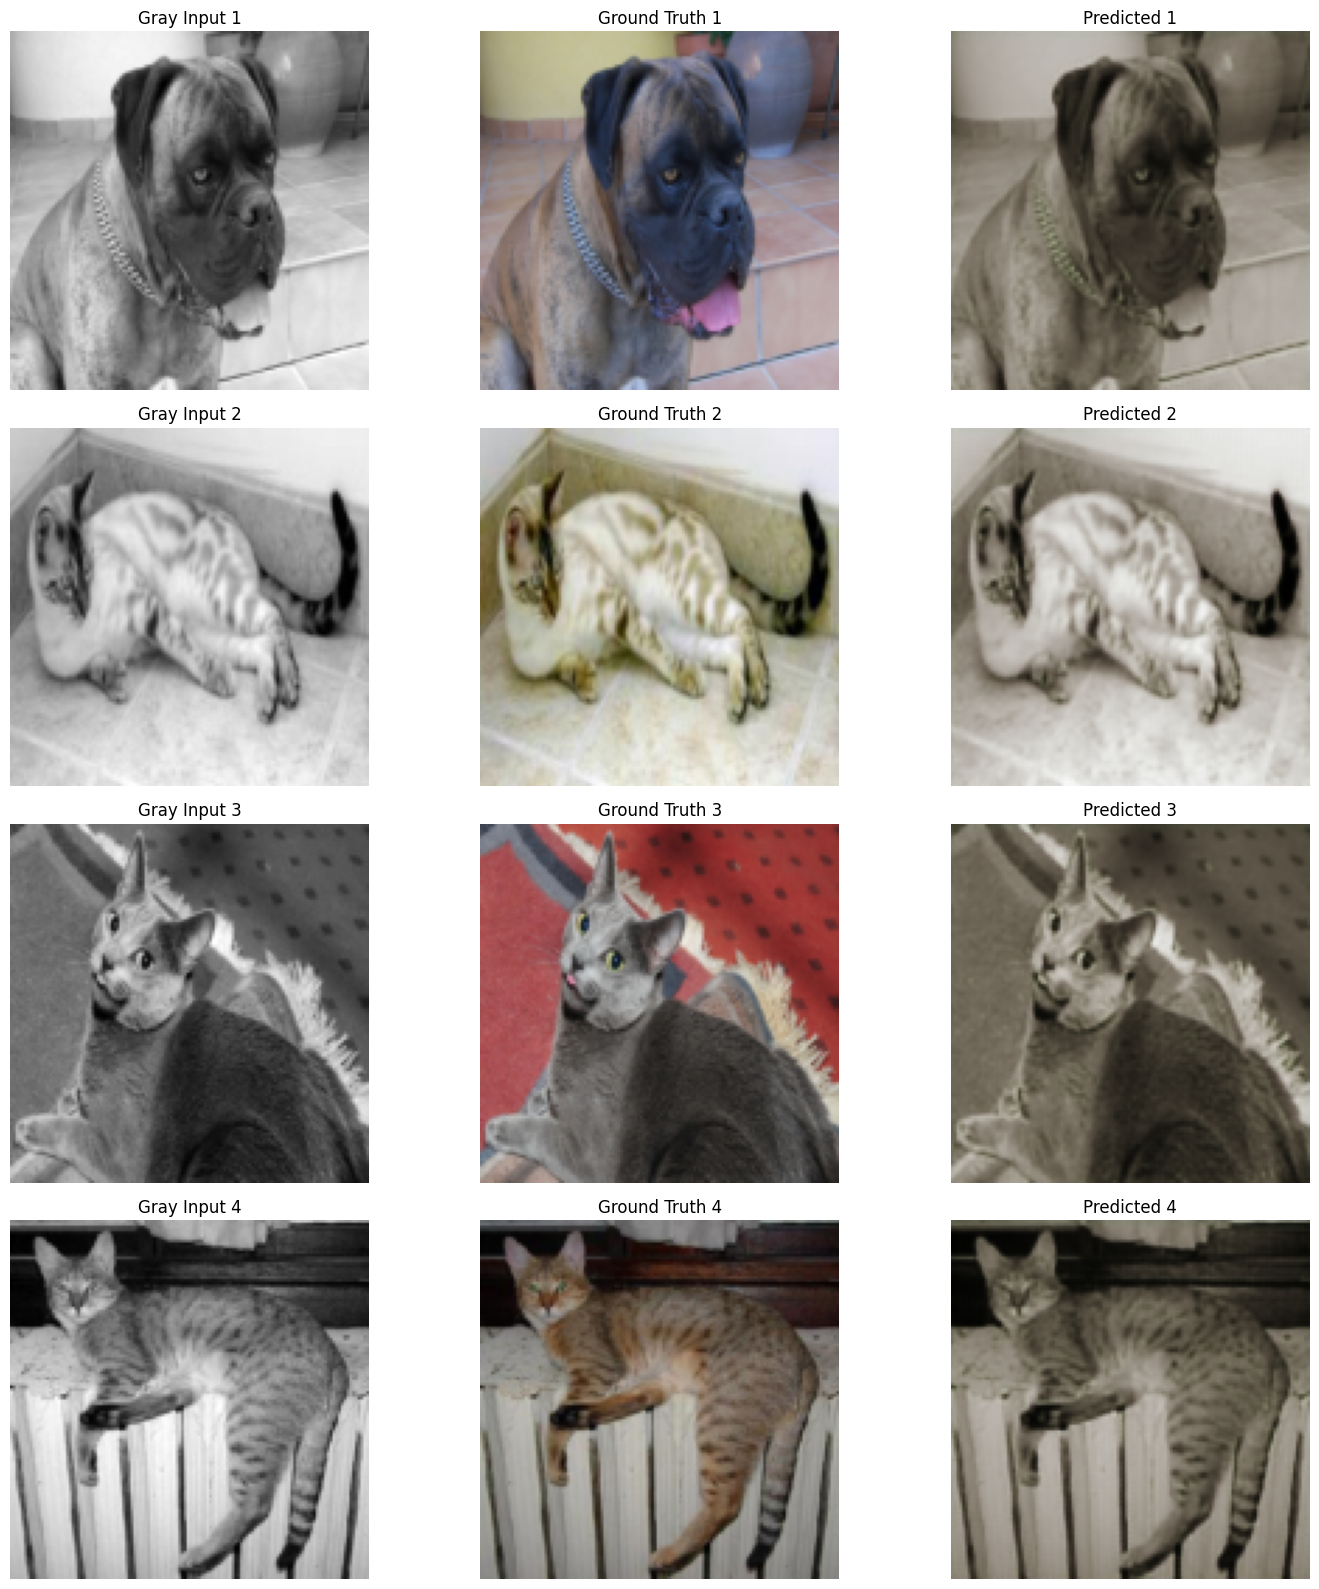

In [28]:
model.eval()

data_iter = iter(train_loader)
gray_imgs, color_imgs = next(data_iter)
gray_imgs = gray_imgs.to(device)

with torch.no_grad():
    outputs = model(gray_imgs)

N = 4  # Number of images to display (make sure N <= batch_size)

plt.figure(figsize=(15, 4*N))  # Height scaled for rows

for i in range(N):
    gray_np = gray_imgs[i].cpu().squeeze().numpy()
    color_np = color_imgs[i].permute(1, 2, 0).numpy()
    output_np = outputs[i].permute(1, 2, 0).cpu().numpy()

    plt.subplot(N, 3, 3*i+1)
    plt.title(f"Gray Input {i+1}")
    plt.imshow(gray_np, cmap='gray')
    plt.axis('off')

    plt.subplot(N, 3, 3*i+2)
    plt.title(f"Ground Truth {i+1}")
    plt.imshow(color_np)
    plt.axis('off')

    plt.subplot(N, 3, 3*i+3)
    plt.title(f"Predicted {i+1}")
    plt.imshow(output_np)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [29]:
# Cell to save your trained model

import torch

# Save the model state_dict (recommended way)
torch.save(model.state_dict(), "colorization_model.pth")

print("Model saved as colorization_model.pth")


Model saved as colorization_model.pth


In [ ]:
model.eval()

data_iter = iter(train_loader)
gray_imgs, color_imgs = next(data_iter)
gray_imgs = gray_imgs.to(device)

with torch.no_grad():
    outputs = model(gray_imgs)

N = 4  # Number of images to display (make sure N <= batch_size)

plt.figure(figsize=(15, 4*N))  # Height scaled for rows

for i in range(N):
    gray_np = gray_imgs[i].cpu().squeeze().numpy()
    color_np = color_imgs[i].permute(1, 2, 0).numpy()
    output_np = outputs[i].permute(1, 2, 0).cpu().numpy()

    plt.subplot(N, 3, 3*i+1)
    plt.title(f"Gray Input {i+1}")
    plt.imshow(gray_np, cmap='gray')
    plt.axis('off')

    plt.subplot(N, 3, 3*i+2)
    plt.title(f"Ground Truth {i+1}")
    plt.imshow(color_np)
    plt.axis('off')

    plt.subplot(N, 3, 3*i+3)
    plt.title(f"Predicted {i+1}")
    plt.imshow(output_np)
    plt.axis('off')

plt.tight_layout()
plt.show()
